In [1]:
import os, sys, h5py
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score

import tensorflow.compat.v1.keras.backend as K1

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

np.random.seed(33) # for reproducibility

In [2]:
import helper 

# load data
data_path = '../data/synthetic_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
#true_index = np.where(y_test[:,0] == 1)[0]
X = x_test#[true_index]
X_model = test_model#[true_index]
print(X.shape)

(6000, 200, 4)


In [5]:
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
import helper
from tfomics import utils, metrics

#------------------------------------------------------------------------

num_trials = 10
model_names = ['cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['relu', 'exponential']

results_path = utils.make_directory('../results', 'synthetic')
params_path = utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------
results = {}
results2 = {}

for model_name in model_names:
    for activation in activations:
        results[model_name+'_'+activation] = []
        results2[model_name+'_'+activation] = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model, name = helper.load_model(model_name, 
                                            activation=activation, 
                                            dropout=True, 
                                            l2=1e-6, 
                                            bn=True,
                                            input_shape=200)
            base_name = name+'_'+activation
            name = base_name+'_'+str(trial)
            print('model: ' + name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            #model.load_weights(weights_path)        
            
            sess = K1.get_session()
            w = sess.run(model.layers[1].kernel)
            w2 = np.sum(np.max(w, axis=1), axis=0)
            beta = sess.run(model.layers[2].beta)
            gamma = sess.run(model.layers[2].gamma)
            val = w2*gamma + beta
            results[model_name+'_'+activation].append(val)

            w2 = np.sum(np.min(w, axis=1), axis=0)
            beta = sess.run(model.layers[2].beta)
            gamma = sess.run(model.layers[2].gamma)
            val = w2*gamma + beta
            results2[model_name+'_'+activation].append(val)
        

model: cnn-deep_do_l2_bn_relu_0
model: cnn-deep_do_l2_bn_relu_1
model: cnn-deep_do_l2_bn_relu_2
model: cnn-deep_do_l2_bn_relu_3
model: cnn-deep_do_l2_bn_relu_4
model: cnn-deep_do_l2_bn_relu_5
model: cnn-deep_do_l2_bn_relu_6
model: cnn-deep_do_l2_bn_relu_7
model: cnn-deep_do_l2_bn_relu_8
model: cnn-deep_do_l2_bn_relu_9
model: cnn-deep_do_l2_bn_exponential_0
model: cnn-deep_do_l2_bn_exponential_1
model: cnn-deep_do_l2_bn_exponential_2
model: cnn-deep_do_l2_bn_exponential_3
model: cnn-deep_do_l2_bn_exponential_4
model: cnn-deep_do_l2_bn_exponential_5
model: cnn-deep_do_l2_bn_exponential_6
model: cnn-deep_do_l2_bn_exponential_7
model: cnn-deep_do_l2_bn_exponential_8
model: cnn-deep_do_l2_bn_exponential_9


In [6]:

w_exp = np.array(results['cnn-deep_exponential'])
w_relu = np.array(results['cnn-deep_relu'])
w_exp2 = np.array(results2['cnn-deep_exponential'])
w_relu2 = np.array(results2['cnn-deep_relu'])


([<matplotlib.axis.YTick at 0x7f0e2c58c8d0>,
 <a list of 3 Text yticklabel objects>)

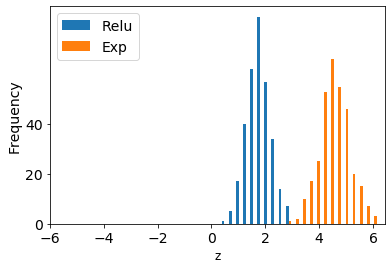

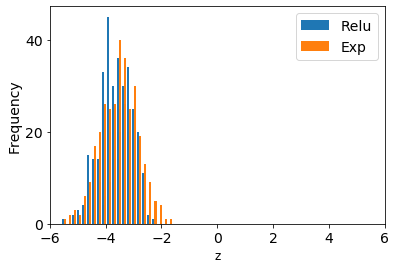

In [106]:
#bins = np.linspace(-10, 10, 30)
x = np.reshape(w_relu, [-1])
y = np.reshape(w_exp, [-1])
fig = plt.figure()
plt.hist([x, y], bins=22, label=['Relu', 'Exp'])
plt.legend(loc='upper left', fontsize=14)
#plt.title('CNN', fontsize=12)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('z', fontsize=12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6], fontsize=14)
plt.yticks([0, 20, 40], fontsize=14)

#bins = np.linspace(-10, 10, 30)
x = np.reshape(w_relu2, [-1])
y = np.reshape(w_exp2, [-1])
fig = plt.figure()
plt.hist([x, y], bins=22, label=['Relu', 'Exp'])
plt.legend(loc='upper right', fontsize=14)
#plt.title('CNN', fontsize=12)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('z', fontsize=12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6], fontsize=14)
plt.yticks([0, 20, 40], fontsize=14)


([<matplotlib.axis.YTick at 0x7f07598c3128>,
 <a list of 3 Text yticklabel objects>)

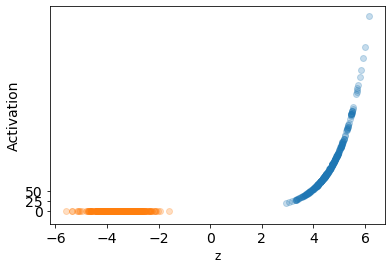

In [110]:
fig = plt.figure()
plt.scatter(np.reshape(w_exp, [-1]), np.exp(np.reshape(w_exp, [-1])), alpha=0.25)
plt.scatter(np.reshape(w_exp2, [-1]), np.exp(np.reshape(w_exp2, [-1])), alpha=0.25)
plt.ylabel('Activation', fontsize=14)
plt.xlabel('z', fontsize=12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6], fontsize=14)
plt.yticks([0, 25, 50], fontsize=14)


([<matplotlib.axis.YTick at 0x7f07582d2dd8>,
 <a list of 3 Text yticklabel objects>)

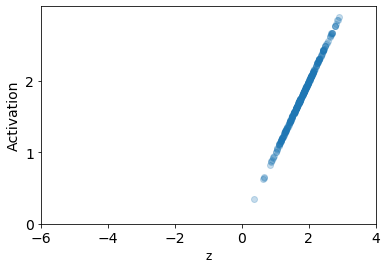

In [96]:
fig = plt.figure()
plt.scatter(np.reshape(w_relu, [-1]), np.maximum(np.reshape(w_relu, [-1]), 0), alpha=0.25)
plt.ylabel('Activation', fontsize=14)
plt.xlabel('z', fontsize=12)
plt.xticks([-6, -4, -2, 0, 2, 4], fontsize=14)
plt.yticks([0, 1, 2], fontsize=14)

In [7]:
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
import helper
from tfomics import utils, metrics

#------------------------------------------------------------------------

num_trials = 10
model_names = ['cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['exponential', 'relu']

results_path = utils.make_directory('../results', 'synthetic')
params_path = utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------
results = {}
results2 = {}
for model_name in model_names:
    for activation in activations:
        results[model_name+'_'+activation] = []
        results2[model_name+'_'+activation] = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model, name = helper.load_model(model_name, 
                                            activation=activation, 
                                            dropout=True, 
                                            l2=1e-6, 
                                            bn=True,
                                            input_shape=200)
            base_name = name+'_'+activation
            name = base_name+'_'+str(trial)
            print('model: ' + name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            #model.load_weights(weights_path)            
            
            intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
            results[model_name+'_'+activation].append(intermediate.predict(X))
        
        
            intermediate2 = keras.Model(inputs=model.inputs, outputs=model.layers[2].output)
            results2[model_name+'_'+activation].append(intermediate2.predict(X))
        

model: cnn-deep_do_l2_bn_exponential_0
model: cnn-deep_do_l2_bn_exponential_1
model: cnn-deep_do_l2_bn_exponential_2
model: cnn-deep_do_l2_bn_exponential_3
model: cnn-deep_do_l2_bn_exponential_4
model: cnn-deep_do_l2_bn_exponential_5
model: cnn-deep_do_l2_bn_exponential_6
model: cnn-deep_do_l2_bn_exponential_7
model: cnn-deep_do_l2_bn_exponential_8
model: cnn-deep_do_l2_bn_exponential_9
model: cnn-deep_do_l2_bn_relu_0
model: cnn-deep_do_l2_bn_relu_1
model: cnn-deep_do_l2_bn_relu_2
model: cnn-deep_do_l2_bn_relu_3
model: cnn-deep_do_l2_bn_relu_4
model: cnn-deep_do_l2_bn_relu_5
model: cnn-deep_do_l2_bn_relu_6
model: cnn-deep_do_l2_bn_relu_7
model: cnn-deep_do_l2_bn_relu_8
model: cnn-deep_do_l2_bn_relu_9


In [8]:
#bins = np.linspace(-10, 10, 30)
x = np.reshape(np.array(results['cnn-deep_exponential'])[0][:100], [-1])
y = np.reshape(np.array(results[model_name+'_'+activation])[0][:100], [-1])
x2 = np.reshape(np.array(results2['cnn-deep_exponential'])[0][:100], [-1])
y2 = np.reshape(np.array(results2[model_name+'_'+activation])[0][:100], [-1])
               

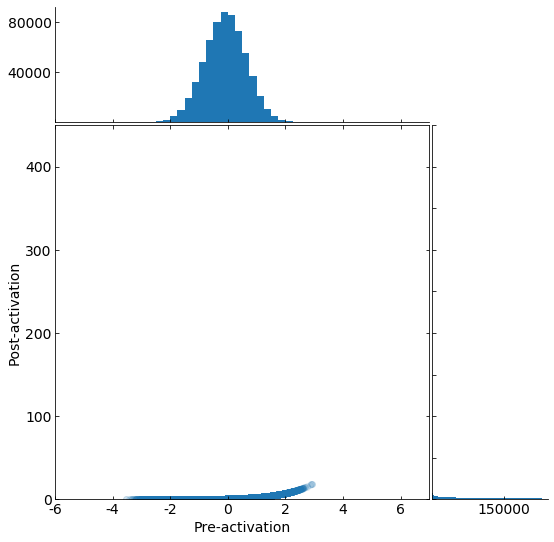

In [13]:
           
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xlabel('Pre-activation', fontsize=14)
plt.ylabel('Post-activation', fontsize=14)

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter.set_yticks([0,100,200,300,400])
ax_scatter.set_yticklabels([0,100,200,300,400], fontsize=14)
ax_scatter.set_xticks([-6, -4, -2, 0, 2, 4, 6])
ax_scatter.set_xticklabels([-6, -4, -2, 0, 2, 4, 6], fontsize=14)

# the scatter plot:
ax_scatter.scatter(x2, x, alpha=0.1, rasterized=True)

# now determine nice limits by hand:
binwidth = 0.25
ax_scatter.set_xlim((-6, 7))
ax_scatter.set_ylim((-0, 450))

bins = np.arange(-6,6 + binwidth, binwidth)
ax_histx.hist(x2, bins=bins)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.set_yticks([40000,80000])
ax_histx.set_yticklabels([40000,80000], fontsize=14)

ax_histy.hist(x, bins=30, orientation='horizontal')
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.set_xticks([150000])
ax_histy.set_xticklabels([150000], fontsize=14)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

outfile = os.path.join('pre-post_activation_exp_random.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


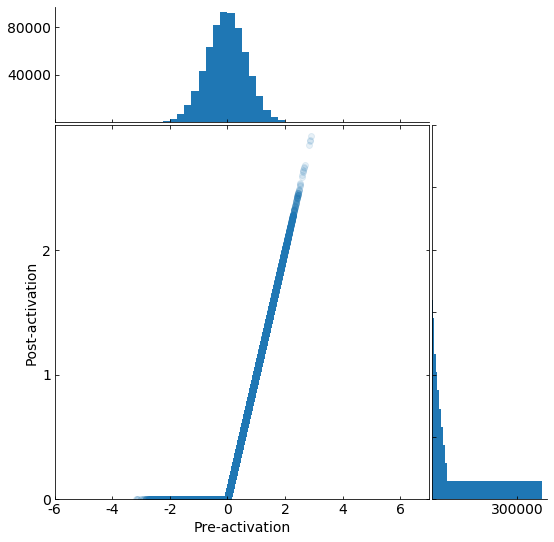

In [11]:
           
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xlabel('Pre-activation', fontsize=14)
plt.ylabel('Post-activation', fontsize=14)

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter.set_yticks([0,1,2])
ax_scatter.set_yticklabels([0,1,2], fontsize=14)
ax_scatter.set_xticks([-6, -4, -2, 0, 2, 4, 6])
ax_scatter.set_xticklabels([-6, -4, -2, 0, 2, 4, 6], fontsize=14)

# the scatter plot:
ax_scatter.scatter(y2,y, alpha=0.1, rasterized=True)

# now determine nice limits by hand:
binwidth = 0.25
ax_scatter.set_xlim((-6, 7))
ax_scatter.set_ylim((-0, 3))

bins = np.arange(-6,6 + binwidth, binwidth)
ax_histx.hist(y2, bins=bins)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.set_yticks([40000, 80000])
ax_histx.set_yticklabels([40000, 80000], fontsize=14)

ax_histy.hist(y, bins=20, orientation='horizontal')
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.set_xticks([300000])
ax_histy.set_xticklabels([300000], fontsize=14)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

outfile = os.path.join('pre-post_activation_relu_random.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


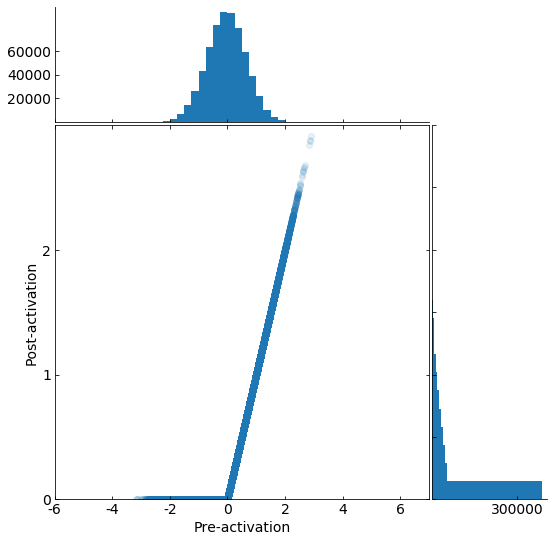

In [10]:
           
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
plt.xlabel('Pre-activation', fontsize=14)
plt.ylabel('Post-activation', fontsize=14)

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_scatter.set_yticks([0,1,2])
ax_scatter.set_yticklabels([0,1,2], fontsize=14)
ax_scatter.set_xticks([-6, -4, -2, 0, 2, 4, 6])
ax_scatter.set_xticklabels([-6, -4, -2, 0, 2, 4, 6], fontsize=14)

# the scatter plot:
ax_scatter.scatter(y2,y, alpha=0.1, rasterized=True)

# now determine nice limits by hand:
binwidth = 0.25
ax_scatter.set_xlim((-6, 7))
ax_scatter.set_ylim((-0, 3))

bins = np.arange(-6,6 + binwidth, binwidth)
ax_histx.hist(y2, bins=bins)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.set_yticks([20000,40000, 60000])
ax_histx.set_yticklabels([20000,40000, 60000], fontsize=14)

ax_histy.hist(y, bins=20, orientation='horizontal')
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.set_xticks([300000])
ax_histy.set_xticklabels([300000], fontsize=14)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

outfile = os.path.join('pre-post_activation_relu_random.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


Text(0.5, 0, 'z')

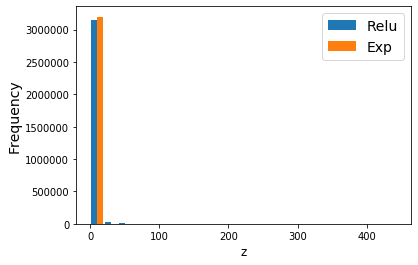

In [117]:
           
fig = plt.figure()
plt.hist([x, y], bins=22, label=['Relu', 'Exp'])
plt.legend(loc='upper right', fontsize=14)
#plt.title('CNN', fontsize=12)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('z', fontsize=12)
#plt.xticks([-6, -4, -2, 0, 2, 4, 6], fontsize=14)
#plt.yticks([0, 20, 40], fontsize=14)

In [133]:
np.max(y)
np.max(x)


443.6909

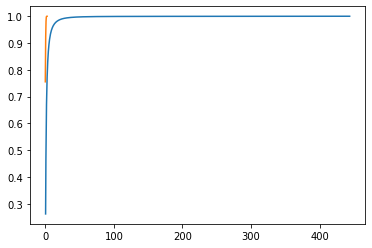

In [130]:
n1, edges1 = np.histogram(x,bins=1000)
n2, edges2 = np.histogram(y,bins=1000)

plt.plot(edges1[1:],np.cumsum(n1)/np.sum(n1))
plt.plot(edges2[1:],np.cumsum(n2)/np.sum(n2))
#plt.xscale('log')
